In [ ]:
# Be sure to run this first!
from utils_notebook_init import init_notebook
init_notebook()

Section 1: File Path Collection

Collect all .wav file paths from the dataset folder (recursively) and infer their labels from filenames.
Then we export the list to data/audio_filepaths.csv for reproducible access in later steps.

In [ ]:
import pandas as pd
from src.data_loader import get_audio_file_paths, export_file_list_to_csv

In [ ]:
data_dir = "data/raw"
files, labels = get_audio_file_paths(data_dir)

print(f"✅ Found {len(files)} audio files in {data_dir}")
print("Example file paths:", files[:3])
print("Example labels:", labels[:3])

In [ ]:
output_csv = "data/audio_filepaths.csv"
export_file_list_to_csv(files, labels, output_csv)

In [ ]:
df = pd.read_csv(output_csv)
print(f"✅ CSV successfully created at: {output_csv}")
display(df.head())
print(f"Unique labels found: {df['label'].nunique()}")
print("Label distribution:")
print(df['label'].value_counts())


Section 2: Data Splitting

Split the dataset into train, validation, and test sets using the file list from audio_filepaths.csv.
Each subset keeps balanced class proportions (stratified).
Output files:
- data/train_split.csv
- data/val_split.csv
- data/test_split.csv

In [ ]:
from sklearn.model_selection import train_test_split
import pandas as pd

In [ ]:
# Step 1: Load the audio file paths CSV
df = pd.read_csv("data/audio_filepaths.csv")
print(f"Total samples: {len(df)}")
print(df.head())

In [ ]:
# Step 2: Split into train / test first
train_df, test_df = train_test_split(
    df,
    test_size=0.2,
    random_state=42,
    stratify=df["label"]
)

In [ ]:
# Step 3: Split train into train / val
train_df, val_df = train_test_split(
    train_df,
    test_size=0.15,
    random_state=42,
    stratify=train_df["label"]
)

print(f"Train: {len(train_df)}, Val: {len(val_df)}, Test: {len(test_df)}")

In [ ]:
# Step 4: save them for future reuse
train_df.to_csv("data/train_split.csv", index=False)
val_df.to_csv("data/val_split.csv", index=False)
test_df.to_csv("data/test_split.csv", index=False)
print("✅ Saved data splits to CSV.")

Section 3: Normalization

Normalize audio waveforms to ensure consistent amplitude range.
The mean and std are computed from the training set only,
then applied to all splits for consistency.

In [ ]:
import numpy as np
import librosa
import pandas as pd

# --- Load split files ---
train_df = pd.read_csv("data/train_split.csv")
val_df   = pd.read_csv("data/val_split.csv")
test_df  = pd.read_csv("data/test_split.csv")

In [ ]:

# --- Step 1: Compute mean and std from training set ---
def compute_mean_std(file_list):
    all_samples = []
    for f in file_list:
        y, _ = librosa.load(f, sr=None, mono=True)
        all_samples.append(y)
    all_concat = np.concatenate(all_samples)
    mean = np.mean(all_concat)
    std = np.std(all_concat)
    return mean, std

mean, std = compute_mean_std(train_df["filepath"])
print(f"Training data mean: {mean:.6f}, std: {std:.6f}")

In [ ]:
# --- Step 2: Define normalization function ---
def normalize_audio(file_path, mean, std):
    y, sr = librosa.load(file_path, sr=None, mono=True)
    # standardization
    y_norm = (y - mean) / std   
    return y_norm, sr
    

In [ ]:
# Example test on one file
sample_file = train_df["filepath"].iloc[0]
y_norm, sr = normalize_audio(sample_file, mean, std)
print(f"✅ Normalized one file: {sample_file}, sr={sr}")

In [ ]:
# --- Step 3: Test stabilized normalization function ---

from src.preprocessing import fit_audio_normalizer, apply_audio_normalization

# Compute global mean/std from training set
mean, std = fit_audio_normalizer(train_df["filepath"])
print(f"Training set mean={mean:.6f}, std={std:.6f}")

# Apply normalization on one example file
y_norm, sr = apply_audio_normalization(train_df["filepath"].iloc[0], mean, std)
print(f"✅ Normalized one file successfully, shape={y_norm.shape}")

Training set mean=-0.000263, std=0.121323
✅ Normalized one file successfully, shape=(112000,)


In [13]:
# --- Step 4: Apply Normalization to All Splits ---

import numpy as np
import librosa
import os
import soundfile as sf
from src.preprocessing import apply_audio_normalization

# Target directory to save normalized audio
output_dir = "data/normalized_wav"
os.makedirs(output_dir, exist_ok=True)

def normalize_and_save(file_list, mean, std, output_dir):
    normalized_paths = []
    os.makedirs(output_dir, exist_ok=True)
    for f in file_list:
        y_norm, sr = apply_audio_normalization(f, mean, std)
        out_path = os.path.join(output_dir, os.path.basename(f))
        sf.write(out_path, y_norm, sr) 
        normalized_paths.append(out_path)
    return normalized_paths

# Apply to all splits
train_norm_files = normalize_and_save(train_df["filepath"], mean, std, f"{output_dir}/train")
val_norm_files   = normalize_and_save(val_df["filepath"], mean, std, f"{output_dir}/val")
test_norm_files  = normalize_and_save(test_df["filepath"], mean, std, f"{output_dir}/test")

print(f"✅ Normalized {len(train_norm_files)} train, {len(val_norm_files)} val, {len(test_norm_files)} test files.")


✅ Normalized 347 train, 62 val, 103 test files.


Section 4: Feature Extraction (MFCC)

Extract MFCCs from the normalized audio files.
MFCCs describe the spectral envelope and frequency dynamics of baby cries,
serving as the foundation for both baseline and deep learning models.
For the baseline SVM model, we will later summarize each MFCC sequence into a fixed-length vector (mean + std).

Output files:
- data/mfcc/train_mfcc.npy
- data/mfcc/val_mfcc.npy
- data/mfcc/test_mfcc.npy

In [ ]:
import librosa
import numpy as np
import pandas as pd
import os
from tqdm import tqdm

# --- Define parameters ---
N_MFCC = 40        # number of MFCC coefficients to extract
SR = 16000         # sampling rate (same as preprocessing)
DURATION = 8.0     # fixed duration in seconds
SAMPLES = int(SR * DURATION)

def extract_mfcc(file_path, n_mfcc=N_MFCC, sr=SR):
    """
    Extract MFCCs from one normalized audio file.
    Returns: MFCC array of shape [n_mfcc, time_frames].
    """
    y, _ = librosa.load(file_path, sr=sr, mono=True)
    # pad/truncate to fixed length for consistency
    if len(y) < SAMPLES:
        y = np.pad(y, (0, SAMPLES - len(y)))
    else:
        y = y[:SAMPLES]
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
    return mfcc

# --- Helper function to process a split ---
def process_split(split_name, folder_path, n_mfcc=N_MFCC):
    print(f"Extracting MFCCs for {split_name} split...")
    filepaths = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.endswith('.wav')]
    X = []
    for f in tqdm(filepaths):
        mfcc = extract_mfcc(f, n_mfcc=n_mfcc)
        X.append(mfcc)
    os.makedirs("data/mfcc", exist_ok=True)
    
    X = np.array(X, dtype=object)
    np.save(f"data/mfcc/{split_name}_mfcc.npy", X)
    print(f"✅ Saved {split_name} MFCCs to data/mfcc/{split_name}_mfcc.npy")
    return X

# --- Run for all splits ---
train_mfcc = process_split("train", "data/normalized_wav/train")
val_mfcc   = process_split("val", "data/normalized_wav/val")
test_mfcc  = process_split("test", "data/normalized_wav/test")


In [ ]:
# Check mfcc.npy files

import numpy as np

train_mfcc = np.load("data/mfcc/train_mfcc.npy", allow_pickle=True)
val_mfcc   = np.load("data/mfcc/val_mfcc.npy", allow_pickle=True)
test_mfcc  = np.load("data/mfcc/test_mfcc.npy", allow_pickle=True)

print(f"Train MFCC count: {len(train_mfcc)}")
print(f"One sample shape: {train_mfcc[0].shape}")

# Visualization

import matplotlib.pyplot as plt

mfcc_sample = np.array(train_mfcc[0], dtype=float)
plt.imshow(mfcc_sample, aspect='auto', origin='lower')
plt.title("MFCC Example")
plt.colorbar()
plt.show()


Secion 4.1: Use Modular MFCC Extraction Functions

In [18]:
from src.features import extract_split_mfcc

train_mfcc = extract_split_mfcc("train", "data/normalized_wav/train")
val_mfcc   = extract_split_mfcc("val", "data/normalized_wav/val")
test_mfcc  = extract_split_mfcc("test", "data/normalized_wav/test")

Extracting MFCCs (train): 100%|███████████| 344/344 [00:01<00:00, 199.72it/s]


✅ Saved train MFCCs to data/mfcc/train_mfcc.npy


Extracting MFCCs (val): 100%|███████████████| 62/62 [00:00<00:00, 192.04it/s]


✅ Saved val MFCCs to data/mfcc/val_mfcc.npy


Extracting MFCCs (test): 100%|████████████| 103/103 [00:00<00:00, 202.14it/s]


✅ Saved test MFCCs to data/mfcc/test_mfcc.npy


Section 5: Prepare MFCC Inputs for CNN Model

Convert the extracted MFCC arrays into a fixed-size 4D tensor suitable for CNN input.
Each sample is padded or truncated along the time axis to the same width and expanded with a single channel dimension.

Output files:
- data/mfcc_cnn/train_mfcc_cnn.npy
- data/mfcc_cnn/val_mfcc_cnn.npy
- data/mfcc_cnn/test_mfcc_cnn.npy

In [ ]:
import numpy as np
import os

# --- Load MFCC arrays ---
train_mfcc = np.load("data/mfcc/train_mfcc.npy", allow_pickle=True)
val_mfcc   = np.load("data/mfcc/val_mfcc.npy", allow_pickle=True)
test_mfcc  = np.load("data/mfcc/test_mfcc.npy", allow_pickle=True)

# --- Define target shape ---
N_MFCC = 40
MAX_FRAMES = 173  # typical for 8s audio with sr=16k, hop_length=512

def pad_or_trim_mfcc(mfcc, max_frames=MAX_FRAMES):
    """Ensure all MFCC matrices have the same width (time frames)."""
    if mfcc.shape[1] < max_frames:
        pad_width = max_frames - mfcc.shape[1]
        mfcc = np.pad(mfcc, ((0, 0), (0, pad_width)), mode="constant")
    else:
        mfcc = mfcc[:, :max_frames]
    return mfcc

def prepare_cnn_input(mfcc_list):
    """Convert a list of MFCCs into a 4D tensor for CNN."""
    X = np.stack([pad_or_trim_mfcc(m) for m in mfcc_list]).astype(np.float32)
    X = X[..., np.newaxis]  # add channel dimension
    return X

# --- Prepare CNN inputs ---
print("Preparing CNN-ready inputs...")
X_train = prepare_cnn_input(train_mfcc)
X_val   = prepare_cnn_input(val_mfcc)
X_test  = prepare_cnn_input(test_mfcc)

print(f"Train shape: {X_train.shape}")
print(f"Val shape:   {X_val.shape}")
print(f"Test shape:  {X_test.shape}")

# --- Save for CNN model training ---
os.makedirs("data/mfcc_cnn", exist_ok=True)
np.save("data/mfcc_cnn/train_mfcc_cnn.npy", X_train)
np.save("data/mfcc_cnn/val_mfcc_cnn.npy", X_val)
np.save("data/mfcc_cnn/test_mfcc_cnn.npy", X_test)
print("✅ Saved CNN-ready MFCC inputs to data/mfcc_cnn/")

Preparing CNN-ready inputs...
Train shape: (344, 40, 173, 1)
Val shape:   (62, 40, 173, 1)
Test shape:  (103, 40, 173, 1)
✅ Saved CNN-ready MFCC inputs to data/mfcc_cnn/


Train shape: (344, 40, 173, 1)
Val shape:   (62, 40, 173, 1)
Test shape:  (103, 40, 173, 1)
One sample shape: (40, 173, 1)
Data type: float32


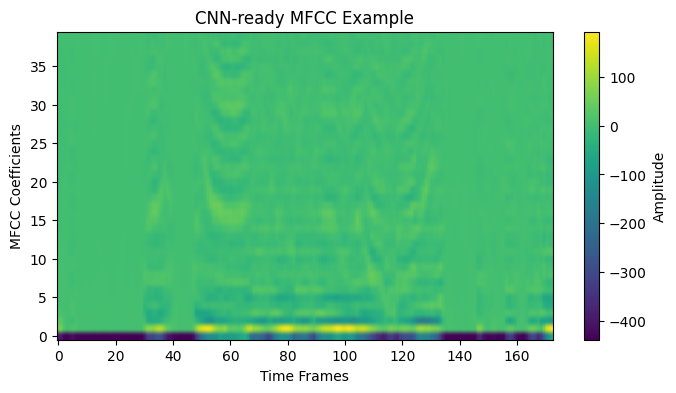

In [23]:
# Verify mfcc_cnn.npy files

import numpy as np

# Load CNN-ready MFCC tensors
train_cnn = np.load("data/mfcc_cnn/train_mfcc_cnn.npy")
val_cnn   = np.load("data/mfcc_cnn/val_mfcc_cnn.npy")
test_cnn  = np.load("data/mfcc_cnn/test_mfcc_cnn.npy")

# Check shapes
print(f"Train shape: {train_cnn.shape}")
print(f"Val shape:   {val_cnn.shape}")
print(f"Test shape:  {test_cnn.shape}")

# Check one sample
print(f"One sample shape: {train_cnn[0].shape}")
print(f"Data type: {train_cnn.dtype}")

# Visualization
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 4))
plt.imshow(train_cnn[0, :, :, 0], aspect='auto', origin='lower')
plt.title("CNN-ready MFCC Example")
plt.xlabel("Time Frames")
plt.ylabel("MFCC Coefficients")
plt.colorbar(label="Amplitude")
plt.show()

Shape: (5, 40, 173, 1)
Dtype: float32


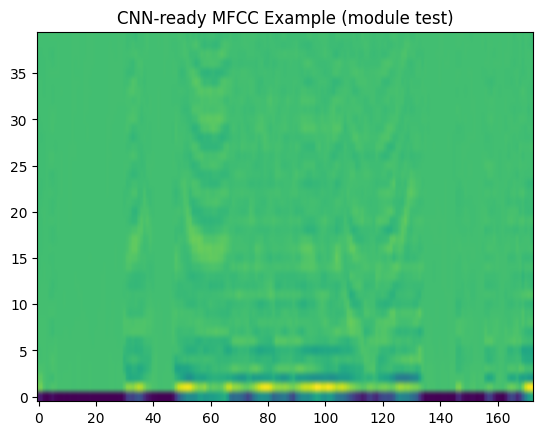

In [25]:
# Verify Modularized CNN Preparation Functions

import importlib
import src.features

importlib.reload(src.features)
from src.features import pad_or_trim_mfcc, prepare_cnn_input
import numpy as np

# Load existing MFCC features (just a few for quick verification)
train_mfcc = np.load("data/mfcc/train_mfcc.npy", allow_pickle=True)

# Use the stabilized function from src/features.py
X_sample = prepare_cnn_input(train_mfcc[:5])  # only first 5 for test

print("Shape:", X_sample.shape)
print("Dtype:", X_sample.dtype)

# Optional quick visualization
import matplotlib.pyplot as plt
plt.imshow(X_sample[0, :, :, 0], aspect="auto", origin="lower")
plt.title("CNN-ready MFCC Example (module test)")
plt.show()
